**Refernces:**

[1] Yibo Wang, Mingming Wang, and Wei XuA - Sentiment-Enhanced Hybrid Recommender System for Movie Recommendation: A Big Data Analytics Framework: https://www.hindawi.com/journals/wcmc/2018/8263704/

[2] Susan Li - Building and Testing Recommender Systems With Surprise, Step-By-Step: https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

[3] Surprise Library: http://surpriselib.com/



In [0]:
import sys
import pandas as pd
import numpy as np

In [0]:
#download the data by passing the absolute path of file. The file is in gz format, so requires extraction.
path='Complete_Data_new.gz'
data = pd.read_csv(path, compression='gzip')
#data=pd.read_csv('Complete_Data.csv')

In [0]:
# Read the first 100 records
data.head()

,Unnamed: 0,text_reviews_count,country_code,language_code,popular_shelves,is_ebook,average_rating,description,authors,publication_year,book_id,ratings_count,title,title_without_series,user_id,review_id,is_read,rating,date_added,date_updated,read_at,started_at,review_text,n_votes,n_comments,authorid
0,0,1,US,NaN,"[{'count': '228', 'name': 'to-read'}, {'count'...",True,4.12,Lillian Ann Cross is forced to live the worst ...,"[{'author_id': '8551671', 'role': ''}]",NaN,25742454,1,The Switchblade Mamma,The Switchblade Mamma,f1830550c10246b9924d03fbb7858a3b,cadab2ad2d162553b3b6b2a5884ec0ea,True,5,Wed Jun 15 16:38:58 -0700 2016,Wed Jun 15 16:38:59 -0700 2016,Wed Jun 15 16:38:59 -0700 2016,NaN,Raw and amazing \n This book is unlike any oth...,0.0,0.0,['8551671']
1,1,2,US,fre,"[{'count': '2', 'name': 'bd'}, {'count': '2', ...",False,3.94,"Florence Dupre Latour raconte comment, de son ...","[{'author_id': '3274315', 'role': ''}]",2016.0,30128855,16,Cruelle,Cruelle,12c0f4c16b6cad9f595fc99f3dcb49d4,60158dd333055f54053506e590cc1291,True,4,Mon May 09 05:03:09 -0700 2016,Tue May 10 07:07:51 -0700 2016,Mon May 09 00:00:00 -0700 2016,NaN,NaN,NaN,NaN,['3274315']
2,2,2,US,fre,"[{'count': '2', 'name': 'bd'}, {'count': '2', ...",False,3.94,"Florence Dupre Latour raconte comment, de son ...","[{'author_id': '3274315', 'role': ''}]",2016.0,30128855,16,Cruelle,Cruelle,bdd5da2d7c778880e20573efd4df888a,a4b605858b28feff2cb14018839950d1,True,5,Sat Jan 21 07:18:46 -0800 2017,Sun Feb 05 06:35:09 -0800 2017,Sun Feb 05 06:35:09 -0800 2017,Sat Jan 21 00:00:00 -0800 2017,NaN,NaN,NaN,['3274315']
3,3,2,US,fre,"[{'count': '2', 'name': 'bd'}, {'count': '2', ...",False,3.94,"Florence Dupre Latour raconte comment, de son ...","[{'author_id': '3274315', 'role': ''}]",2016.0,30128855,16,Cruelle,Cruelle,15b0c6dbe18c5e493b39aaa30cb6d2b8,111f1d4941d77877558c4a4ffff87239,False,0,Mon Apr 24 08:28:14 -0700 2017,Mon Apr 24 08:28:20 -0700 2017,NaN,NaN,NaN,NaN,NaN,['3274315']
4,4,2,US,fre,"[{'count': '2', 'name': 'bd'}, {'count': '2', ...",False,3.94,"Florence Dupre Latour raconte comment, de son ...","[{'author_id': '3274315', 'role': ''}]",2016.0,30128855,16,Cruelle,Cruelle,dc9f898ef44e9d38d8eb92a7bde1341d,831e2005e78a56b1f90b26877eeea1f3,True,2,Sun Aug 28 16:15:38 -0700 2016,Thu Sep 08 16:51:22 -0700 2016,Thu Sep 08 16:51:22 -0700 2016,NaN,NaN,NaN,NaN,['3274315']


In [0]:
#data['review_text'].describe()

In [0]:
#Grouping of rating column and aggregating the number of ratings for visulaization
Overall_Rating=data.groupby(['rating'])['review_id'].count().reset_index()

In [0]:
Overall_Rating=Overall_Rating.rename(columns={'review_id':'Number_of_Reviews'})
Overall_Rating

,rating,Number_of_Reviews
0,0,2833536
1,1,48757
2,2,209939
3,3,937833
4,4,1627804
5,5,1689761


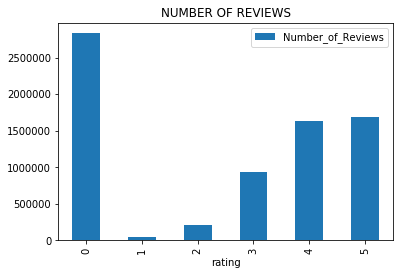

In [0]:
# plot graph of number of reviews verus ratings
import matplotlib.pyplot as plt
Overall_Rating.plot(x="rating",y="Number_of_Reviews",kind="bar",title="NUMBER OF REVIEWS")
plt.show()

In [0]:
#remove the records that does not have reviews.
data=data[~data['review_text'].isnull()]

In [0]:
#check the data info
#data.info()

In [0]:
# Filtering rarely rated books and users from data
min_book_ratings = 15
filter_books = data['book_id'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 15
filter_users = data['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = data[(data['book_id'].isin(filter_books)) & (data['user_id'].isin(filter_users))]
#print('The original data frame shape:\t{}'.format(data.shape))
#print('The new data frame shape:\t{}'.format(df_new.shape))

In [0]:
#only consider the columns (title, user_id, book_id, rating) that are required for collaborative filtering
df= df_new[['title','user_id','book_id','rating']]

In [0]:
#len(df.user_id.unique())

In [0]:
#len(df.book_id.unique())

In [0]:
# Importing required librairs from surprise. 
# We need to define reader object to parse dataframe.
from surprise import Reader,Dataset
reader = Reader()
sdata = Dataset.load_from_df(df[['user_id','book_id','rating']], reader)

In [0]:
# Using whole dataset as train set. We make use of build_full_trainset method which builds trainset object.
from surprise.model_selection import train_test_split
trainset = sdata.build_full_trainset()

In [0]:
''' We build the model by making use of KNNWithMeans which is collaborative filtering based algorithm. 
    We are setting minimum number of neighbous (min_k) 10 and maximum number of neighbours (k) = 20  
    We train the model on train set '''
from surprise import KNNWithMeans, accuracy
sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between items
               }
algo = KNNWithMeans(sim_options=sim_options,k=20,min_k=10)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:248: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


In [0]:
''' We build test set using build_anti_testset() method. 
 Return a list of ratings that can be used as a testset in the test() method.
 The ratings are all the ratings that are not in the trainset, i.e. all the ratings rui where the user u is known, 
 the item i is known, but the rating rui is not in the trainset. 
 As actual rating is unknown, it is either replaced by the fill value or assumed to be equal to the mean of all ratings global_mean'''
testset = trainset.build_anti_testset()

In [0]:
# We find the predictions for all the records in testset. 
predictions = algo.test(testset)

In [0]:
# We compute the RMSE of our module.
accuracy.rmse(predictions, verbose=True)

RMSE: 0.6483


0.6483381810428145

In [0]:
#predictions

In [0]:
# Return the top-N recommendation for each user from a set of predictions.

from collections import defaultdict

def get_top_n(predictions, n=10):
    '''
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, r_ui, est, details in predictions:
        top_n[uid].append((iid, est,details))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid) in user_ratings])

In [19]:
# Return the top-N recommendation for given user from a set of predictions.
from collections import defaultdict

def get_top_n_for_given_uid(input_uid, predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n_for_uid = defaultdict(list)
    for uid, iid, r_ui, est, _ in predictions:
        if(uid==input_uid):
            top_n_for_uid[uid].append((iid, est))
    #print(top_n_for_uid.items())

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n_for_uid.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n_for_uid[uid] = user_ratings[:n]

    return top_n_for_uid
input_uid='7557e15e7c2a067b5263d5bf6d3e8996'
top_n_single_uid = get_top_n_for_given_uid(input_uid, predictions, n=20)

# Print the recommended items for each user
for uid, user_ratings in top_n_single_uid.items():
    print(uid, [iid for (iid) in user_ratings])

7557e15e7c2a067b5263d5bf6d3e8996 [(5322056, 5), (24812, 5), (300946, 4.983083952730112), (299796, 4.9418849074894435), (17131869, 4.904580318897093), (25066780, 4.8943003212379885), (920607, 4.881042454358495), (18594409, 4.872860868647017), (8569434, 4.830411600707912), (3886240, 4.828571578067937), (23753, 4.824683658522966), (29507117, 4.8111278800707815), (13228306, 4.806101888089083), (13532252, 4.796843118461933), (11381638, 4.784148893313518), (12160809, 4.761468300158703), (7668272, 4.7544826376307645), (6394175, 4.727739991468356), (25363212, 4.726626784135068), (22487952, 4.715523407775142)]


In [0]:
# Converting the top N recommendations to dataframe.
book_recommendations=pd.DataFrame(top_n_single_uid)

In [0]:
#top_recommendations_input_id['Top_10']=top_recommendations_input_id[]
book_recommendations[['recommended_books','predicted_rating']]=pd.DataFrame(book_recommendations[input_uid].tolist(), index=book_recommendations.index)    

In [22]:
book_recommendations.drop([input_uid], axis=1)

,recommended_books,predicted_rating
0,5322056,5.000000
1,24812,5.000000
2,300946,4.983084
3,299796,4.941885
4,17131869,4.904580
5,25066780,4.894300
6,920607,4.881042
7,18594409,4.872861
8,8569434,4.830412
9,3886240,4.828572


In [0]:
# Converting Top book recommendations dataframe to list
Rec_books_list = book_recommendations['recommended_books'].tolist()

In [0]:
inner_uid=algo.trainset.to_inner_uid(input_uid)

In [0]:
#getiing the top k neighbors of the user using the trained model.
topknn=algo.get_neighbors(inner_uid, k=50)

In [0]:
# converting the inner user id's to raw id (original user id).
top_neighbous_id=[]
for i in topknn:
    #print(algo.trainset.to_raw_uid(i))
    top_neighbous_id.append(algo.trainset.to_raw_uid(i))

In [0]:
#top_neighbous_id

In [0]:
# Extracting all the records which contains the users that are nearest neighbours of given user and books that are top recommendations for given user 
d1=df_new['book_id'].isin(Rec_books_list) & df_new['user_id'].isin(top_neighbous_id)

In [0]:
d2=df_new[d1]

In [0]:
# extracting only user_id, book_id and review_text columns required for sentiment analysis.
d3=d2[['title','user_id','book_id','review_text']]

In [0]:
# Sorting the values by book_id
d3=d3.sort_values(by=['book_id'])

In [31]:
d3

,title,user_id,book_id,review_text
1489035,X-23: Innocence Lost,59717d48561cdc1b5492e48af8f702d1,299796,"Weapon X, a lot of time and money was put into..."
3816332,The Arrival,67f3e6a5c5e0c3a06472c252a87120d6,920607,"A lovely piece, and definitely something I'd h..."
3812726,The Arrival,2a1eed8348a005c77251928b500f17e8,920607,Apparently my rating was not high enough for s...
3812713,The Arrival,ec03edf05716d58082c8e4da0e40339c,920607,I noted in my previous review of Tan's Lost an...
3812123,The Arrival,bcdc2c010dd5a9788f4d7c96b04c69cc,920607,A beautifully illustrated wordless tale that d...
...,...,...,...,...
6748239,"The Vision, Volume 2: Little Better than a Beast",59cdb05d55b7592357c098d2b95cb32d,29507117,How is it that a series about androids can off...
6748320,"The Vision, Volume 2: Little Better than a Beast",c239503224fc0f3b667ead2d07a802c5,29507117,"""In sooth, I know not why I am so sad..."" - Fi..."
6748365,"The Vision, Volume 2: Little Better than a Beast",201117ef7fdfd4079cb07458ec7e4543,29507117,I'm impressed with the backstory that we had i...
6748514,"The Vision, Volume 2: Little Better than a Beast",1656fa00b5310a63df6ef14b1060f100,29507117,Ended as great as it started. This was a diffe...


In [0]:
# get all the records wose book_id are in Recoomneded books list for given user
only_books=df_new['book_id'].isin(Rec_books_list)

In [0]:
books_for_review=df_new[only_books]

In [34]:
len(books_for_review)

2434

In [0]:
# extracting only user_id, book_id and review_text columns required for sentiment analysis.
books_for_review=books_for_review[['title','book_id','user_id','review_text']]

In [0]:
#books_for_review

In [0]:
d3.to_csv('Top_Recommendations.csv')

[1] 'Mahalakshmi Arunachalam'. Sentiment-analysis-on-Amazon-Reviews-using-Python: https://github.com/Maha41/Sentiment-analysis-on-Amazon-Reviews-using-Python/blob/master/Analysis/Analysis_1.ipynb

[2] Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014

[3] https://github.com/cjhutto/vaderSentiment

In [0]:
#VADER (Valence Aware Dictionary and Sentiment Reasoner) Sentiment analysis tool was used to calculate the sentiment of reviews.
# Installing required libraries for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
import string
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer

In [0]:
# langdetect is library used to detect language of sentences.
from langdetect import DetectorFactory 
DetectorFactory.seed = 0 

In [0]:
# function to detect language of sentence
def apply_detect(row):
    try:
        return detect(row['review_text'])
    except:
        return 'en'

In [0]:
# detect language of each review and store it in new column 'lang_code'
from langdetect import detect
d3['lang_code']=d3.apply(apply_detect, axis=1)

In [0]:
''' For each review, if not in english translate it to english and
    then apply vader sentiment analyser to detect sentiment score for 
    each review and store it in new column 'Sentiment_Score'   '''
import requests 
import json
analyzer = SentimentIntensityAnalyzer()
def calculate_Sentiment_Score(row):
        sentence = row['review_text']
        from_lang = row['lang_code']
        to_lang = "en"
        if (from_lang == "en") or (from_lang == "en-US"):
            translation = sentence
            translator_name = "No translation needed"
        else:  # please note usage limits for My Memory Translation Service:   http://mymemory.translated.net/doc/usagelimits.php
                # using   MY MEMORY NET   http://mymemory.translated.net
            api_url = "http://mymemory.translated.net/api/get?q={}&langpair={}|{}".format(sentence, from_lang,to_lang)
            hdrs = {
                    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
                    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                    'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
                    'Accept-Encoding': 'none',
                    'Accept-Language': 'en-US,en;q=0.8',
                    'Connection': 'keep-alive'}
            response = requests.get(api_url, headers=hdrs)
            response_json = json.loads(response.text)
            translation = response_json["responseData"]["translatedText"]
            translator_name = "MemoryNet Translation Service"
        vs = analyzer.polarity_scores(translation)
        score=vs['compound']
        return(score)

In [0]:
d3['Sentiment_Score']=d3.apply(calculate_Sentiment_Score, axis=1)

In [0]:
# Clasifying Sentiment as positive, negative and neutral of each review text and saving it in 'Sentiment' column.
def calculate_Sentiment(row):
    score=row['Sentiment_Score']
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'

d3['Sentiment']=d3.apply(calculate_Sentiment, axis=1)

In [46]:
d3

,title,user_id,book_id,review_text,lang_code,Sentiment_Score,Sentiment
1489035,X-23: Innocence Lost,59717d48561cdc1b5492e48af8f702d1,299796,"Weapon X, a lot of time and money was put into...",en,-0.9907,neg
3816332,The Arrival,67f3e6a5c5e0c3a06472c252a87120d6,920607,"A lovely piece, and definitely something I'd h...",en,0.9471,pos
3812726,The Arrival,2a1eed8348a005c77251928b500f17e8,920607,Apparently my rating was not high enough for s...,en,0.0516,neu
3812713,The Arrival,ec03edf05716d58082c8e4da0e40339c,920607,I noted in my previous review of Tan's Lost an...,en,0.9583,pos
3812123,The Arrival,bcdc2c010dd5a9788f4d7c96b04c69cc,920607,A beautifully illustrated wordless tale that d...,en,0.0772,neu
...,...,...,...,...,...,...,...
6748239,"The Vision, Volume 2: Little Better than a Beast",59cdb05d55b7592357c098d2b95cb32d,29507117,How is it that a series about androids can off...,en,0.0000,neu
6748320,"The Vision, Volume 2: Little Better than a Beast",c239503224fc0f3b667ead2d07a802c5,29507117,"""In sooth, I know not why I am so sad..."" - Fi...",en,0.9724,pos
6748365,"The Vision, Volume 2: Little Better than a Beast",201117ef7fdfd4079cb07458ec7e4543,29507117,I'm impressed with the backstory that we had i...,en,0.9918,pos
6748514,"The Vision, Volume 2: Little Better than a Beast",1656fa00b5310a63df6ef14b1060f100,29507117,Ended as great as it started. This was a diffe...,en,0.8616,pos


In [0]:
neu = d3.loc[d3['Sentiment'] == 'neu']
pos = d3.loc[d3['Sentiment'] == 'pos']
neg = d3.loc[d3['Sentiment'] == 'neg']

In [0]:
def stemming(tokens):
    ps=PorterStemmer()
    stem_words=[]
    for x in tokens:
        stem_words.append(ps.stem(x))
    return stem_words

In [0]:
def create_Word_Corpus(df):
    words_corpus = ''
    for val in df["review_text"]:
        text = val.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = stemming(tokens)
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus

In [0]:
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
   # plt.savefig('wordclouds.png', facecolor='k', bbox_inches='tight')

In [51]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
pos_wordcloud = WordCloud(width=600, height=400).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=600, height=400).generate(create_Word_Corpus(neg))
#neu_wordcloud = WordCloud(width=600, height=500).generate(create_Word_Corpus(neu))

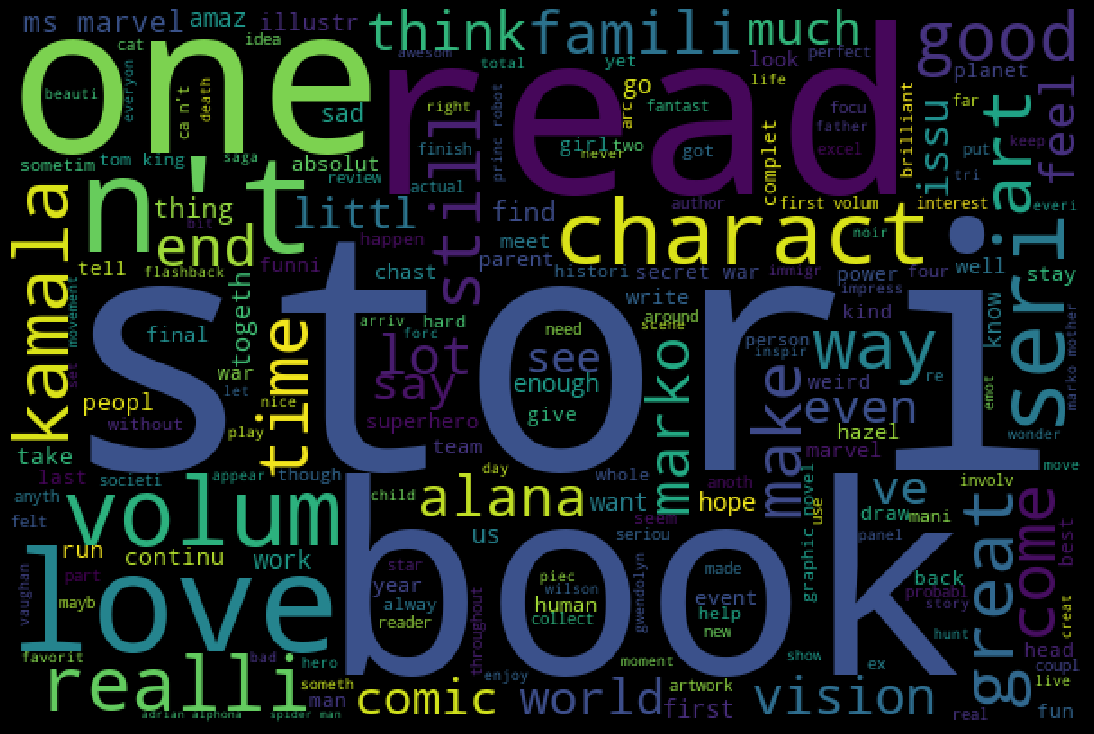

In [53]:
plot_Cloud(pos_wordcloud)


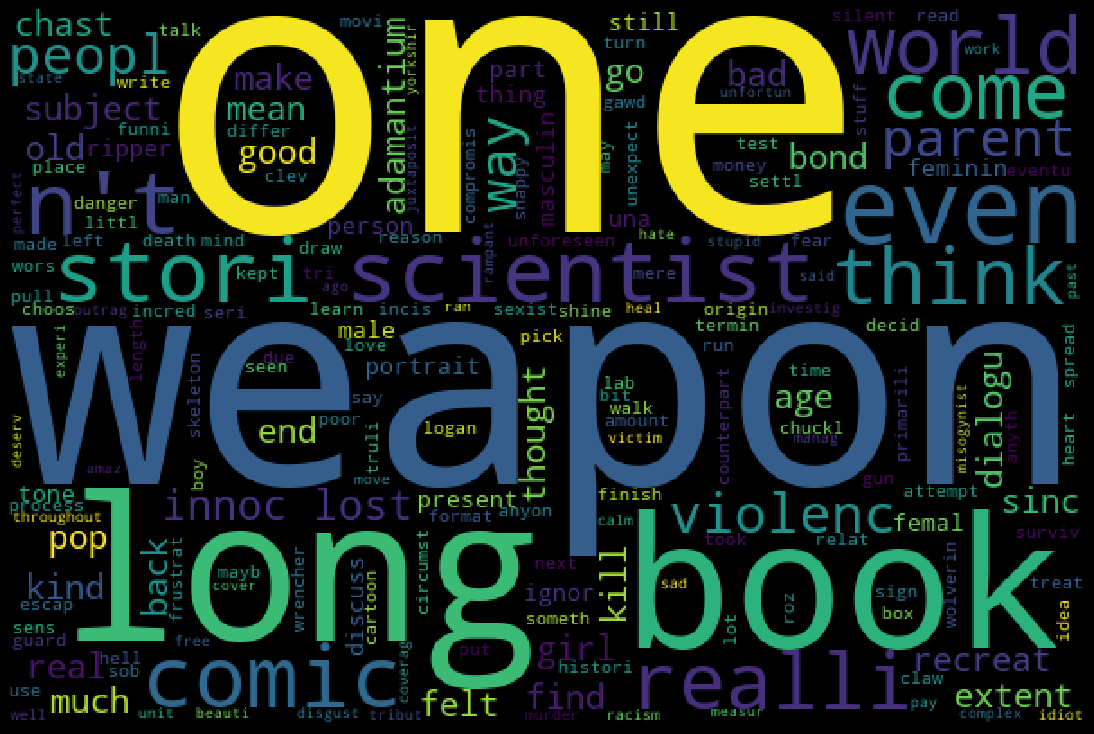

In [54]:
plot_Cloud(neg_wordcloud)

In [0]:
#Using Groupby on ''book_id' calculate the sum of all sentiment Score
Sentimemt_Score_Product1=d3.groupby(['title','book_id']).sum()

In [56]:
Sentimemt_Score_Product1

,,Sentiment_Score
title,book_id,
Astonishing X-Men: Omnibus,6394175,0.9907
Becoming Unbecoming,25363212,-0.3189
Can't We Talk about Something More Pleasant?,18594409,0.9680
"Criminal, Vol. 6: The Last of the Innocent",11381638,-0.0569
Journalism,12160809,0.2245
"March: Book Two (March, #2)",22487952,2.6343
"Ms. Marvel, Vol. 4: Last Days",25066780,10.1415
"Saga, Vol. 2 (Saga, #2)",17131869,11.1574
"Scalped, Vol. 10: Trail's End (Scalped, #10)",13532252,2.2387


In [0]:
# Sort the books based on thier Sentiment Score and these are the top ten recommendations.
Sentimemt_Score_Product1=Sentimemt_Score_Product1.sort_values(['Sentiment_Score'],ascending=False)

In [0]:
Top_20_books=Sentimemt_Score_Product1

In [0]:
Top_10_books=Top_20_books.drop(columns=['Sentiment_Score']).head(10)

In [60]:
# Top 10 book recommendations for user '7557e15e7c2a067b5263d5bf6d3e8996'
Top_10_books

,
title,book_id
"Saga, Vol. 2 (Saga, #2)",17131869
"Ms. Marvel, Vol. 4: Last Days",25066780
"The Vision, Volume 2: Little Better than a Beast",29507117
The Arrival,920607
"March: Book Two (March, #2)",22487952
"Scalped, Vol. 10: Trail's End (Scalped, #10)",13532252
"Scalped, Vol. 6: The Gnawing (Scalped, #6)",7668272
"Scalped, Vol. 9: Knuckle Up (Scalped, #9)",13228306
"Scalped, Vol. 7: Rez Blues (Scalped, #7)",8569434
